#### 1. Environment Setup & Data Loading

In [1]:
#!pip install catboost
#!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- עיבוד נתונים (Preprocessing) ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- מודלים (Models) ---
# קבוצה 1: לינאריים ומרחקיים
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN

# קבוצה 2: עצי החלטה ו-Ensembles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# קבוצה 3: בוסטינג מתקדם
from catboost import CatBoostClassifier

# --- מדדים להערכה (Metrics) ---
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score, 
    roc_auc_score,
    silhouette_score  # <--- קריטי למודלים הלא מפוקחים (K-Means/DBSCAN)
)

# --- הגדרות תצוגה וניקוי רעשים ---
pd.set_option('display.max_columns', None) # להציג את כל העמודות
import warnings
warnings.filterwarnings('ignore') # השתקת אזהרות לא קריטיות

print("All libraries imported successfully.")

# --- Load Data ---
# Update this path to your folder
base_path = r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data"

print("Loading datasets...")

# Load Features (X)
X_train = pd.read_csv(f"{base_path}/X_train.csv")
X_train_noisy = pd.read_csv(f"{base_path}/X_train_noisy.csv") # For experiments
X_test = pd.read_csv(f"{base_path}/X_test.csv")

# Load Targets (y) - using squeeze to make them Series
y_train = pd.read_csv(f"{base_path}/y_train.csv").squeeze()
y_test = pd.read_csv(f"{base_path}/y_test.csv").squeeze()

print(f"Data Loaded. Train Shape: {X_train.shape}")

All libraries imported successfully.
Loading datasets...
Data Loaded. Train Shape: (23795, 23)


##### 2. Feature Engineering

In [2]:
# --- 1. הגדרת הפונקציה ---
def apply_feature_engineering(df):
    # יצירת העתק כדי לא לפגוע בדאטה המקורי בטעות
    df = df.copy()

    # 1. Demographic Interactions
    # Check if race matches (ignoring Unknowns)
    df['same_race'] = ((df['PERP_RACE'] == df['VIC_RACE']) & 
                       (df['PERP_RACE'] != 'Unknown')).astype(int)
    
    # Is the suspect information available or missing?
    df['suspect_info_available'] = (df['PERP_AGE_GROUP'] != 'Unknown').astype(int)

    # 2. Cyclical Time Features
    # This helps models understand that 23:00 is close to 00:00
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 3. Specific Risk Combinations
    # Crimes happening outside at night might have different characteristics
    df['is_night_outdoor'] = ((df['Part_of_Day'] == 'Night') & 
                              (df['LOC_OF_OCCUR_DESC'] == 'OUTSIDE')).astype(int)

    # 4. Vulnerability Features
    # Flagging minor victims
    df['is_minor_victim'] = (df['VIC_AGE_GROUP'] == '<18').astype(int)
    
    return df

# --- 2. הפעלת הפונקציה על כל הסטים ---
print("Applying feature engineering...")
X_train = apply_feature_engineering(X_train)
X_train_noisy = apply_feature_engineering(X_train_noisy)
X_test = apply_feature_engineering(X_test)

print("Feature engineering complete. New columns added.")
print(f"New columns: {[col for col in X_train.columns if col not in ['X_COORD_CD', 'Y_COORD_CD']]}") # הדפסת דוגמה

Applying feature engineering...
Feature engineering complete. New columns added.
New columns: ['BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'LOCATION_GROUP', 'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 'is_weekend', 'holiday_name', 'is_holiday', 'Season', 'same_race', 'suspect_info_available', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_night_outdoor', 'is_minor_victim']


#### 3. High Cardinality Analysis: Visualizing the "Long Tail

--- Distribution Analysis (Top 20 Categories) ---


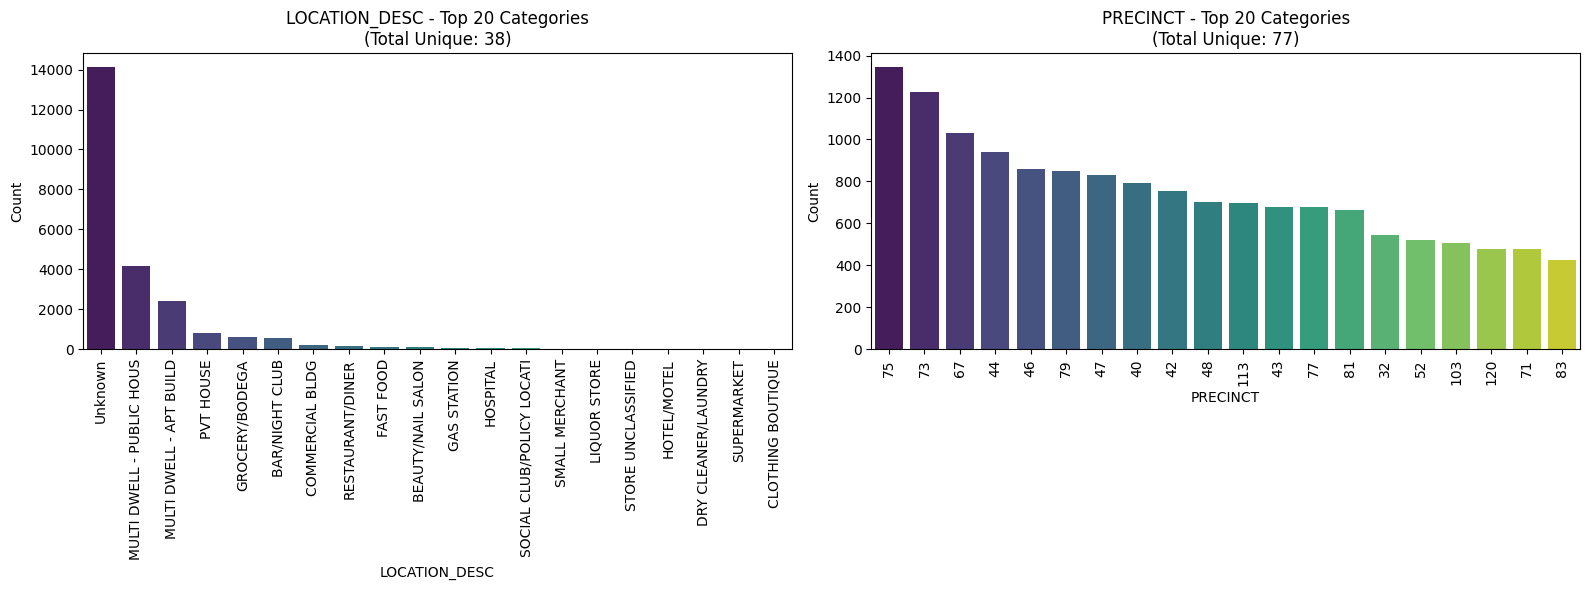


Column 'LOCATION_DESC' has 38 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
LOCATION_DESC
CHECK CASH          1
ATM                 1
LOAN COMPANY        1
STORAGE FACILITY    1
PHOTO/COPY STORE    1
Name: count, dtype: int64

Column 'PRECINCT' has 77 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
PRECINCT
1      20
112    17
111    12
17      8
22      1
Name: count, dtype: int64


In [3]:
# --- הכנת הדאטה לניתוח ---
# אנחנו ממירים את ה-PRECINCT לטקסט כי בקרוב נכניס לשם את הערך "Other" (מחרוזת)
# ואי אפשר לערבב מספרים ומחרוזות באותה עמודה בלי להמיר את כולם ל-Object/Category
X_train['PRECINCT'] = X_train['PRECINCT'].astype(str)
X_test['PRECINCT'] = X_test['PRECINCT'].astype(str)

cols_to_analyze = ['LOCATION_DESC', 'PRECINCT']

print("--- Distribution Analysis (Top 20 Categories) ---")

plt.figure(figsize=(16, 6))
for i, col in enumerate(cols_to_analyze):
    plt.subplot(1, 2, i+1)
    
    # חישוב השכיחות
    counts = X_train[col].value_counts()
    
    # הצגת 20 הקטגוריות הנפוצות ביותר
    sns.barplot(x=counts.head(20).index, y=counts.head(20).values, palette='viridis')
    plt.title(f'{col} - Top 20 Categories\n(Total Unique: {counts.shape[0]})')
    plt.xticks(rotation=90)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# הדפסה טקסטואלית כדי לראות את ה"זנב" (הקטגוריות הנדירות)
for col in cols_to_analyze:
    n_unique = X_train[col].nunique()
    print(f"\nColumn '{col}' has {n_unique} unique categories.")
    print("Bottom 5 rare categories (Candidates for 'Other'):")
    print(X_train[col].value_counts().tail(5))

##### 2.3 Cardinality Reduction: Grouping Rare Labels

In [4]:
# --- Helper Functions for Reduction ---

def get_top_categories(df, col, threshold=0.005):
    """ 
    Returns a list of categories that appear in more than 'threshold' percent of the rows.
    Based on Training Data ONLY.
    """
    counts = df[col].value_counts(normalize=True) # Calculate percentages
    top_cats = counts[counts > threshold].index.tolist()
    return top_cats

def apply_cardinality_reduction(df, col_map):
    """
    Applies the grouping logic: Keep top categories, replace rest with 'Other'.
    """
    df_clean = df.copy()
    for col, allowed_cats in col_map.items():
        if col in df_clean.columns:
            # The lambda function checks membership in the allowed list
            df_clean[col] = df_clean[col].apply(lambda x: x if x in allowed_cats else 'Other')
    return df_clean

# --- Execution Strategy ---

# 1. Define Settings
# Thresholds:
# LOCATION_DESC: 0.5% (0.005) -> Removes very specific/rare locations.
# PRECINCT: 0.2% (0.002) -> Keeps most stations, removes errors/typos only.
threshold_settings = {
    'LOCATION_DESC': 0.005, 
    'PRECINCT': 0.002       
}

reduction_map = {}

# 2. Fit (Learn from Train)
print("Learning frequent categories from Train set...")
for col, thresh in threshold_settings.items():
    if col in X_train.columns:
        top_cats = get_top_categories(X_train, col, threshold=thresh)
        reduction_map[col] = top_cats
        
        # Log the reduction info
        original_count = X_train[col].nunique()
        new_count = len(top_cats) + 1 # +1 for 'Other'
        print(f" -> Column '{col}': Reduced from {original_count} to {new_count} categories (Threshold: {thresh*100}%)")

# 3. Transform (Apply to Train & Test)
print("\nApplying reduction to Train and Test sets...")
X_train_reduced = apply_cardinality_reduction(X_train, reduction_map)
X_test_reduced = apply_cardinality_reduction(X_test, reduction_map)

# 4. Verify Result
print("\nSanity Check (PRECINCT after reduction):")
print(X_train_reduced['PRECINCT'].value_counts().tail())

Learning frequent categories from Train set...
 -> Column 'LOCATION_DESC': Reduced from 38 to 9 categories (Threshold: 0.5%)
 -> Column 'PRECINCT': Reduced from 77 to 66 categories (Threshold: 0.2%)

Applying reduction to Train and Test sets...

Sanity Check (PRECINCT after reduction):
PRECINCT
10     62
5      61
62     58
13     50
122    50
Name: count, dtype: int64



We addressed the high cardinality in categorical features using a frequency-based thresholding approach. To prevent **Data Leakage**, the "popular" categories were identified solely from the **Training Set**, and then applied to the Test Set.

**Methodology:**
1.  **Fit (Train):** Identify categories appearing above a specific threshold percentage.
2.  **Transform (Train & Test):** Keep identified categories; map all rare/unseen categories to a new label `'Other'`.

**Results:**

* **`LOCATION_DESC` (Threshold: 0.5%):**
    * Reduced from **38** to **9** categories.
    * **Analysis:** This feature had a heavy "Long Tail" of specific store types (e.g., 'SHOE STORE', 'VIDEO STORE') with very few occurrences. Grouping these into 'Other' significantly reduces noise and prevents the model from overfitting to anecdotal locations.

* **`PRECINCT` (Threshold: 0.2%):**
    * Reduced from **77** to **66** categories.
    * **Analysis:** Unlike location descriptions, Police Precincts show a flatter distribution (most precincts handle a significant volume of cases).
    * **Decision:** We retained 66 distinct precincts. While 66 is a relatively high number for One-Hot Encoding, this granular geospatial information is critical for prediction. Merging them further would result in loss of valuable local patterns. The 11 removed categories represented extremely low-activity precincts or data entry errors.

##### Correlation Check

Preparing data for correlation check...


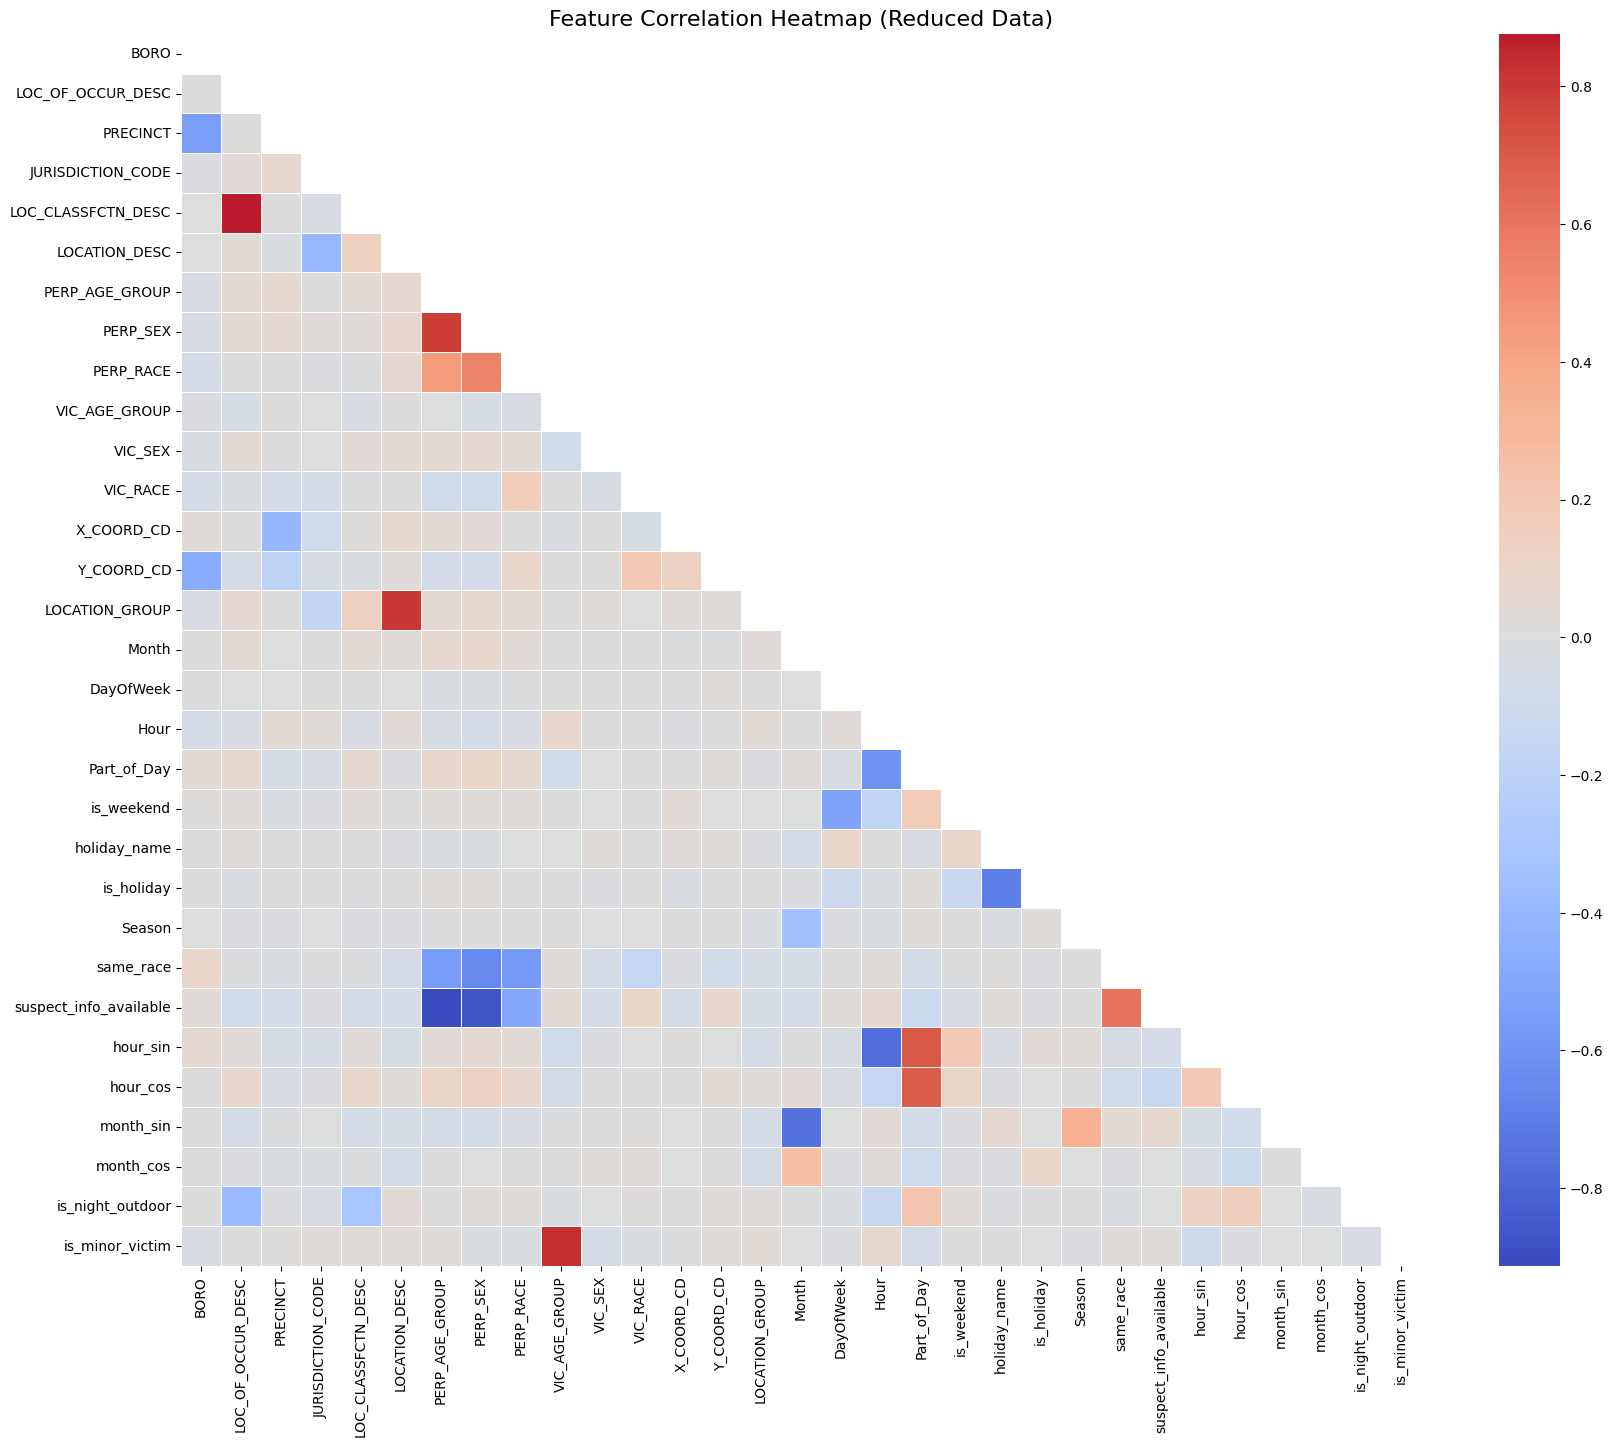


--- Top Correlated Pairs (Threshold > 0.7) ---
PERP_AGE_GROUP <--> suspect_info_available : 0.9130
LOC_CLASSFCTN_DESC <--> LOC_OF_OCCUR_DESC : 0.8762
PERP_SEX <--> suspect_info_available : 0.8665
VIC_AGE_GROUP <--> is_minor_victim : 0.8397
LOCATION_DESC <--> LOCATION_GROUP : 0.8013
PERP_AGE_GROUP <--> PERP_SEX : 0.7907
Hour <--> hour_sin : 0.7671
Month <--> month_sin : 0.7491
Part_of_Day <--> hour_sin : 0.7019

--- Variance Inflation Factor (VIF) Analysis ---
                   Feature          VIF
0                    const  5210.250087
25  suspect_info_available     9.419796
7           PERP_AGE_GROUP     6.161566
19             Part_of_Day     5.689878
2        LOC_OF_OCCUR_DESC     4.793548
8                 PERP_SEX     4.758060
5       LOC_CLASSFCTN_DESC     4.551336
26                hour_sin     3.746163
6            LOCATION_DESC     3.529231
10           VIC_AGE_GROUP     3.504926
31         is_minor_victim     3.500786
1                     BORO     3.371872
3              

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- הכנת הדאטה לבדיקה ---
# אנחנו עובדים על העותק המצומצם שיצרנו
df_analysis = X_train_reduced.copy()

print("Preparing data for correlation check...")

# 1. המרה זמנית של קטגוריות למספרים (כדי ש-.corr יוכל לחשב)
# שים לב: זה רק לצורך הבדיקה הזו, זה לא ה-Encoding הסופי למודל
for col in df_analysis.select_dtypes(include=['object', 'category']).columns:
    df_analysis[col] = df_analysis[col].astype('category').cat.codes

# --- בדיקה 1: Heatmap ויזואלי ---
plt.figure(figsize=(20, 16)) # הגדלנו קצת כי יש הרבה פיצ'רים
correlation_matrix = df_analysis.corr()

# יצירת מסכה להסתיר את החצי העליון (כדי שלא יהיה כפול)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0, 
            linewidths=0.5, annot=False) # annot=False כדי לא להעמיס מספרים, נסתכל על הצבעים
plt.title('Feature Correlation Heatmap (Reduced Data)', fontsize=16)
plt.show()

# --- בדיקה 2: רשימת הזוגות עם קורלציה גבוהה ---
print("\n--- Top Correlated Pairs (Threshold > 0.7) ---")
# הורדנו סף ל-0.7 כדי לתפוס גם קשרים בינוניים-חזקים
corr_pairs = correlation_matrix.abs().unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# סינון: רק זוגות חזקים ולא עצמיים
strong_pairs = sorted_pairs[(sorted_pairs > 0.7) & (sorted_pairs < 1.0)]

unique_pairs = []
for index, value in strong_pairs.items():
    pair = tuple(sorted(index))
    if pair not in unique_pairs:
        unique_pairs.append(pair)
        print(f"{pair[0]} <--> {pair[1]} : {value:.4f}")

# --- בדיקה 3: VIF Analysis (Multicollinearity) ---
print("\n--- Variance Inflation Factor (VIF) Analysis ---")
# הוספת קבוע (דרישה מתמטית של VIF)
X_vif = add_constant(df_analysis)

# טיפול בערכים חסרים אם נשארו (מילוי ב-0 טכני רק לחישוב)
X_vif = X_vif.fillna(0)

# חישוב VIF לכל עמודה
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(X_vif.shape[1])]

# הצגת התוצאות מהגבוה לנמוך
print(vif_data.sort_values("VIF", ascending=False).head(15))
print("\n* Guidelines: VIF > 5 is suspicious, VIF > 10 is critical (Must Fix for Linear Models).")

For the Linear Group (Logistic Regression, K-Means, DBSCAN), we focused on minimizing multicollinearity and reducing dimensionality to ensure mathematical stability:

Redundancy Removal: Excluded suspect_info_available (High VIF) and is_minor_victim (correlated with age) to prevent overfitting.

Temporal Optimization: Replaced raw integers (Hour, Month) with Cyclical Features (Sin/Cos) to correctly represent time continuity.

Dimensionality Reduction: Removed high-cardinality columns (PRECINCT, LOCATION_DESC) to avoid sparse matrices that distort Euclidean distance calculations.

Result: A subset of 20 normalized features, optimized for linear separation and clustering density.

# 1. Feature Selection Strategy
Based on Correlation Matrix, VIF analysis, and Model specific requirements.

In [9]:
# --- 1. Linear & Distance Models (Logistic Regression, K-Means, DBSCAN) ---
# Rationale: 
# - Removed Multicollinearity (High VIF) to stabilize coefficients.
# - Removed High Cardinality (Precinct) to prevent sparse matrix noise.
# - Used Cyclical Time (Sin/Cos) instead of raw integers.
# - Mandatory: Scaling (StandardScaler) & One-Hot Encoding.

linear_cols = [
    'BORO', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'LOCATION_GROUP', 
    'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'same_race',
    'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
    'DayOfWeek', 'is_weekend', 'is_holiday', 'is_night_outdoor'
]

# --- 2. Tree-Based Models (Random Forest, Decision Tree, AdaBoost) ---
# Rationale:
# - Robust to Multicollinearity (can handle redundant features).
# - Prefer raw integers for time (Hour, Month) for easier splits.
# - Can handle Precinct (reduced version) without dimensionality issues.
# - No Scaling required.

tree_cols = [
    'BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC',
    'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 
    'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 
    'X_COORD_CD', 'Y_COORD_CD', 'LOCATION_GROUP', 
    'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 
    'is_weekend', 'holiday_name', 'is_holiday', 'Season', 
    'same_race', 'suspect_info_available', 'is_night_outdoor', 'is_minor_victim'
]

# --- 3. CatBoost (Gradient Boosting) ---
# Rationale:
# - Handles categorical features natively (no One-Hot needed).
# - Handles missing values (NaN) internally.
# - Uses all available information.

catboost_cols = X_train.columns.tolist() # Use Everything

print(f"Linear Features: {len(linear_cols)}")
print(f"Tree Features: {len(tree_cols)}")
print(f"CatBoost Features: All")

Linear Features: 20
Tree Features: 26
CatBoost Features: All


##### Preprocessing Pipelines

In [ ]:
# 1. Pipeline for Linear Group
# כאן הורדנו את ה-Imputer. נשארנו רק עם הנרמול שהוא חובה.
num_lin = ['X_COORD_CD', 'Y_COORD_CD', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
cat_lin = [c for c in linear_cols if c not in num_lin]

preprocessor_linear = ColumnTransformer(
    transformers=[
        # למספרים: רק לנרמל
        ('num', StandardScaler(), num_lin),
        
        # לקטגוריות: רק להפוך למספרים (OneHot)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_lin)
    ])

# 2. Pipeline for Tree Group
# לעצים לא צריך נרמול ולא Imputer (כי ניקית כבר).
num_tree = [c for c in tree_cols if X_train[c].dtype in ['int64', 'float64']]
cat_tree = [c for c in tree_cols if c not in num_tree]

preprocessor_tree = ColumnTransformer(
    transformers=[
        # למספרים: 'passthrough' אומר "אל תיגע, תעביר כמו שזה"
        ('num', 'passthrough', num_tree),
        
        # לקטגוריות: חייבים להמיר למספרים (OneHot) כי Scikit-Learn לא יודע לקרוא מחרוזות
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_tree)
    ])

print("Pipelines created successfully (without Imputation).")

Pipelines created successfully (without Imputation).


##### Models Traning:

##### Supervised:


In [11]:
# === אימון מודל רגרסיה לוגיסטית (Baseline) ===

# 1. חיבור המעבד המוכן למודל
baseline_model = Pipeline([
    ('preprocessor', preprocessor_linear), # המשתנה שיצרנו קודם
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 2. אימון (Fit)
# שים לב: אנחנו שולחים רק את העמודות הלינאריות מתוך הטבלה המלאה
print("Training Baseline Logistic Regression...")
baseline_model.fit(X_train[linear_cols], y_train)

# 3. בדיקת תוצאות
train_acc = baseline_model.score(X_train[linear_cols], y_train)
test_acc = baseline_model.score(X_test[linear_cols], y_test)

print(f"\n--- Baseline Results ---")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

# 4. דוח סיווג מלא (כדי לראות Precision/Recall)
y_pred = baseline_model.predict(X_test[linear_cols])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Baseline Logistic Regression...

--- Baseline Results ---
Train Accuracy: 0.8060
Test Accuracy:  0.8057

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      4796
           1       0.45      0.01      0.02      1153

    accuracy                           0.81      5949
   macro avg       0.63      0.50      0.46      5949
weighted avg       0.74      0.81      0.72      5949



In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer

print("--- Optimizing Logistic Regression (Imbalanced 1:4 Focus) ---")

# 1. Pipeline
# אין צורך בשינוי כאן, הלוגיקה נכנסת בפרמטרים
pipe_lr = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('model', LogisticRegression(max_iter=2000, random_state=42))
])

# 2. Parameter Grid (התאמה לאי-איזון)
param_grid_lr = {
    # המפתח: בדיקה האם לתת משקל שונה למיעוט
    'model__class_weight': [None, 'balanced'], 
    
    # פרמטרים רגילים לחוזק המודל
    'model__C': [0.01, 0.1, 1, 10, 100],            
    'model__solver': ['lbfgs', 'liblinear'] 
}

# 3. GridSearch עם מטריקה מתאימה
# שינוי קריטי: scoring='f1' (במקום accuracy)
# זה יגרום למודל לבחור את הפרמטרים שנותנים את ה-Balance הכי טוב בין Precision ל-Recall
grid_lr = GridSearchCV(
    pipe_lr, 
    param_grid_lr, 
    cv=5, 
    scoring='f1', # <--- השינוי החשוב ביותר!
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train[linear_cols], y_train)

# 4. תוצאות
best_lr = grid_lr.best_estimator_
print(f"Best Params: {grid_lr.best_params_}")
print(f"Best CV F1 Score: {grid_lr.best_score_:.4f}")

# 5. דוח סופי על ה-Test
y_pred_lr = best_lr.predict(X_test[linear_cols])

print("\nTest Report (Optimized for F1 & Balance):")
# כאן נראה אם ה-Recall של קבוצת המיעוט (1) השתפר
print(classification_report(y_test, y_pred_lr))

# בדיקת Threshold (אופציונלי - אם רוצים לשפר Recall עוד יותר)
# לפעמים ברירת המחדל (0.5) לא אופטימלית ב-1:4, אפשר להוריד ל-0.3-0.4
y_proba = best_lr.predict_proba(X_test[linear_cols])[:, 1]

--- Optimizing Logistic Regression (Imbalanced 1:4 Focus) ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'model__C': 100, 'model__class_weight': 'balanced', 'model__solver': 'liblinear'}
Best CV F1 Score: 0.3719

Test Report (Optimized for F1 & Balance):
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      4796
           1       0.26      0.57      0.36      1153

    accuracy                           0.61      5949
   macro avg       0.56      0.60      0.54      5949
weighted avg       0.74      0.61      0.65      5949



In [13]:
from sklearn.metrics import precision_recall_fscore_support

print("--- Fine-Tuning Decision Threshold ---")

# 1. קבלת ההסתברויות (במקום 0/1 סופי)
# אנחנו רוצים את העמודה השנייה (הסיכוי להיות 1)
y_proba = best_lr.predict_proba(X_test[linear_cols])[:, 1]

print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 45)

# 2. בדיקת ספים שונים
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]

best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    # יצירת תחזית לפי הסף הנוכחי
    y_pred_custom = (y_proba >= thresh).astype(int)
    
    # חישוב מדדים לקלאס 1 בלבד (המיעוט)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_custom, average=None)
    
    # הצגת התוצאות עבור קלאס 1 (האינדקס השני)
    print(f"{thresh:<10} {prec[1]:<10.4f} {rec[1]:<10.4f} {f1[1]:<10.4f}")
    
    if f1[1] > best_f1:
        best_f1 = f1[1]
        best_thresh = thresh

print("-" * 45)
print(f"Optimal Threshold seems to be: {best_thresh}")

--- Fine-Tuning Decision Threshold ---
Threshold  Precision  Recall     F1-Score  
---------------------------------------------
0.4        0.2278     0.8985     0.3634    
0.45       0.2445     0.7563     0.3696    
0.5        0.2649     0.5742     0.3625    
0.55       0.2732     0.4241     0.3323    
0.6        0.3203     0.3044     0.3121    
0.65       0.3550     0.1891     0.2467    
0.7        0.3975     0.1093     0.1714    
0.8        0.3438     0.0095     0.0186    
---------------------------------------------
Optimal Threshold seems to be: 0.45


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

print("=== PROJECT: DECISION TREE (End-to-End) ===")

# --- שלב 1: מודל בסיס (Baseline) ---
print("\n1. Training Baseline Decision Tree...")

# שימוש בפייפליין של העצים (ללא נרמול, כי עצים לא צריכים אותו)
pipe_dt_base = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', DecisionTreeClassifier(random_state=42))
])

pipe_dt_base.fit(X_train[tree_cols], y_train)

# בדיקה ראשונית
y_pred_base = pipe_dt_base.predict(X_test[tree_cols])
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_base))


# --- שלב 2: אופטימיזציה (GridSearch) ---
print("\n2. Running Optimization for Decision Tree...")

# כאן אנחנו נלחמים ב-Overfitting ובחוסר האיזון
param_grid_dt = {
    # 1. עומק העץ: עמוק מדי = שינון, רדוד מדי = טיפש
    'model__max_depth': [5, 10, 15, 20, None], 
    
    # 2. מינימום דוגמאות לפיצול: מונע פיצול על מקרים אזוטריים
    'model__min_samples_split': [2, 10, 50, 100],
    
    # 3. קריטריון האיכות: ג'יני או אנטרופיה
    'model__criterion': ['gini', 'entropy'],
    
    # 4. טיפול באי-איזון (קריטי לדאטה שלך!)
    'model__class_weight': [None, 'balanced']
}

# שימוש ב-F1 כדי למצוא את האיזון הטוב ביותר
grid_dt = GridSearchCV(
    pipe_dt_base, 
    param_grid_dt, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train[tree_cols], y_train)

# --- שלב 3: תוצאות סופיות ---
best_dt_model = grid_dt.best_estimator_

print(f"\n3. Optimization Results:")
print(f" -> Best Parameters: {grid_dt.best_params_}")
print(f" -> Best CV F1 Score: {grid_dt.best_score_:.4f}")

print("\nFinal Report (Optimized Tree):")
y_pred_opt = best_dt_model.predict(X_test[tree_cols])
print(classification_report(y_test, y_pred_opt))

=== PROJECT: DECISION TREE (End-to-End) ===

1. Training Baseline Decision Tree...
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4796
           1       0.22      0.22      0.22      1153

    accuracy                           0.69      5949
   macro avg       0.51      0.51      0.51      5949
weighted avg       0.70      0.69      0.69      5949


2. Running Optimization for Decision Tree...
Fitting 5 folds for each of 80 candidates, totalling 400 fits

3. Optimization Results:
 -> Best Parameters: {'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_split': 50}
 -> Best CV F1 Score: 0.3652

Final Report (Optimized Tree):
              precision    recall  f1-score   support

           0       0.86      0.58      0.69      4796
           1       0.26      0.61      0.36      1153

    accuracy                           0.58      5949
   ma

In [15]:
from sklearn.ensemble import RandomForestClassifier

print("=== PROJECT: RANDOM FOREST (End-to-End) ===")

# --- שלב 1: מודל בסיס ---
print("\n1. Training Baseline Random Forest...")
pipe_rf_base = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_rf_base.fit(X_train[tree_cols], y_train)

# בדיקה ראשונית
y_pred_base = pipe_rf_base.predict(X_test[tree_cols])
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_base))

# --- שלב 2: אופטימיזציה (GridSearch) ---
print("\n2. Running Optimization for Random Forest...")

param_grid_rf = {
    # מספר העצים: יותר = יציב יותר (אבל איטי)
    'model__n_estimators': [100, 200],
    
    # עומק: ביער אפשר להיות קצת יותר "פראיים" מעץ בודד
    'model__max_depth': [10, 20, None],
    
    # מינימום דוגמאות בעלה (מונע רעש)
    'model__min_samples_leaf': [1, 2, 4],
    
    # טיפול באי-איזון: 
    # balanced_subsample מחשב משקולות מחדש לכל עץ בנפרד (חזק מאוד!)
    'model__class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = GridSearchCV(
    pipe_rf_base, 
    param_grid_rf, 
    cv=3,            # הורדנו ל-3 קיפולים כי המודל כבד
    scoring='f1',    # עדיין מחפשים את ה-F1 הטוב ביותר למיעוט
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train[tree_cols], y_train)

# --- שלב 3: תוצאות סופיות ---
best_rf_model = grid_rf.best_estimator_

print(f"\n3. Optimization Results:")
print(f" -> Best Parameters: {grid_rf.best_params_}")
print(f" -> Best CV F1 Score: {grid_rf.best_score_:.4f}")

print("\nFinal Report (Optimized Random Forest):")
y_pred_opt = best_rf_model.predict(X_test[tree_cols])
print(classification_report(y_test, y_pred_opt))

=== PROJECT: RANDOM FOREST (End-to-End) ===

1. Training Baseline Random Forest...
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4796
           1       0.18      0.06      0.09      1153

    accuracy                           0.77      5949
   macro avg       0.49      0.50      0.48      5949
weighted avg       0.68      0.77      0.72      5949


2. Running Optimization for Random Forest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

3. Optimization Results:
 -> Best Parameters: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__n_estimators': 100}
 -> Best CV F1 Score: 0.3746

Final Report (Optimized Random Forest):
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      4796
           1       0.27      0.61      0.37      1153

    accuracy                           0.60      59

In [17]:
print("=== PROJECT: CATBOOST (RE-OPTIMIZATION) ===")

# 1. הגדרות
cat_features_indices = np.where(X_train[catboost_cols].dtypes == object)[0]

# 2. הגדרת המודל עם תיקונים
# שינינו את המטריקה ל-AUC כדי למנוע עצירה מוקדמת מדי
# שינינו את המשקל ל-4 באופן ידני (Scale Pos Weight)
model_cat_final = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,       
    depth=6,
    scale_pos_weight=4,       # יחס של 1:4 לטובת המיעוט
    eval_metric='AUC',        # מטריקה יציבה יותר לאימון
    early_stopping_rounds=50, # עדיין שומרים על עצירה מוקדמת, אבל ב-AUC
    verbose=100,
    cat_features=cat_features_indices,
    random_state=42
)

# 3. אימון
print("Training Fixed CatBoost...")
model_cat_final.fit(
    X_train[catboost_cols], y_train,
    eval_set=(X_test[catboost_cols], y_test),
    use_best_model=True
)

# 4. תוצאות
print(f"\nBest Iteration: {model_cat_final.get_best_iteration()}")
print(f"Best AUC: {model_cat_final.get_best_score()['validation']['AUC']:.4f}")

print("\nFinal Report (Fixed CatBoost):")
y_pred_final = model_cat_final.predict(X_test[catboost_cols])
print(classification_report(y_test, y_pred_final))

# 5. בדיקת Threshold אופטימלי (בונוס ל-CatBoost)
# לפעמים ברירת המחדל (0.5) לא מספיקה, נבדוק מה קורה ב-0.6
y_proba_cat = model_cat_final.predict_proba(X_test[catboost_cols])[:, 1]
y_pred_custom = (y_proba_cat >= 0.6).astype(int)
print("\nCheck with Threshold 0.6:")
print(classification_report(y_test, y_pred_custom))

=== PROJECT: CATBOOST (RE-OPTIMIZATION) ===
Training Fixed CatBoost...
0:	test: 0.6320413	best: 0.6320413 (0)	total: 58.4ms	remaining: 58.3s
100:	test: 0.6570415	best: 0.6570415 (100)	total: 6.02s	remaining: 53.6s
200:	test: 0.6605405	best: 0.6605405 (200)	total: 12s	remaining: 47.8s
300:	test: 0.6637067	best: 0.6645758 (271)	total: 18.1s	remaining: 42.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6645758391
bestIteration = 271

Shrink model to first 272 iterations.

Best Iteration: 271
Best AUC: 0.6646

Final Report (Fixed CatBoost):
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      4796
           1       0.27      0.59      0.38      1153

    accuracy                           0.62      5949
   macro avg       0.57      0.61      0.55      5949
weighted avg       0.75      0.62      0.66      5949


Check with Threshold 0.6:
              precision    recall  f1-score   support

           0       0.83  

##### Unsupervised

=== PROJECT: K-MEANS CLUSTERING (Optimization) ===
Preparing data (Scaling)...
Running optimization loop (finding optimal K)...
 -> K=2: Silhouette=0.1057
 -> K=3: Silhouette=0.1042
 -> K=4: Silhouette=0.1101
 -> K=5: Silhouette=0.0979
 -> K=6: Silhouette=0.0963
 -> K=7: Silhouette=0.0859
 -> K=8: Silhouette=0.0873
 -> K=9: Silhouette=0.0853
 -> K=10: Silhouette=0.0873


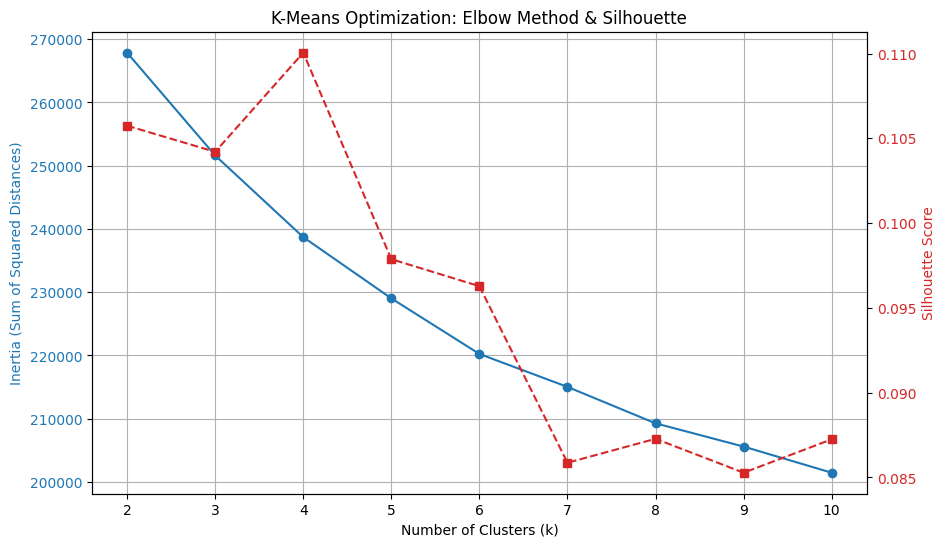

In [18]:
from sklearn.cluster import KMeans

print("=== PROJECT: K-MEANS CLUSTERING (Optimization) ===")

# 1. הכנת הדאטה (Scaling)
# K-Means מודד מרחקים, אז חובה שנשתמש בדאטה מנורמל
print("Preparing data (Scaling)...")
X_scaled = preprocessor_linear.fit_transform(X_train[linear_cols])

# 2. שיטת המרפק (Elbow Method)
# נריץ את המודל עם מספר קבוצות שונה (2 עד 10) ונמדוד את ה"שגיאה" (Inertia)
inertia = []
silhouette_scores = []
K_range = range(2, 11)

print("Running optimization loop (finding optimal K)...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    
    # Inertia: כמה הנקודות קרובות למרכז הקבוצה שלהן (נמוך = טוב)
    inertia.append(kmeans.inertia_)
    
    # Silhouette: עד כמה הקבוצות נפרדות זו מזו (גבוה = טוב)
    # הערה: זה חישוב כבד, אם לוקח יותר מדי זמן אפשר לוותר עליו
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    
    print(f" -> K={k}: Silhouette={score:.4f}")

# 3. ציור הגרף
fig, ax1 = plt.subplots(figsize=(10, 6))

# ציר Y ראשון: Inertia (המרפק)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of Squared Distances)', color='tab:blue')
ax1.plot(K_range, inertia, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# ציר Y שני: Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(K_range, silhouette_scores, 's--', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('K-Means Optimization: Elbow Method & Silhouette')
plt.show()

=== PROJECT: FINAL CLUSTERING ANALYSIS (K=4) ===

--- Crime Profiles Detected (K=4) ---
             BORO  hour_sin  is_night_outdoor VIC_SEX PERP_RACE  \
Cluster                                                           
0        BROOKLYN -0.136219          0.041956       M   Unknown   
1        BROOKLYN -0.218205          0.029064       M     BLACK   
2           BRONX -0.218690          0.039836       M     BLACK   
3          QUEENS -0.114553          0.034058       M     BLACK   

         % Severe Crimes  Size     Size %  
Cluster                                    
0               0.159096  8938  37.562513  
1               0.207101  5746  24.147930  
2               0.229570  6351  26.690481  
3               0.196377  2760  11.599075  


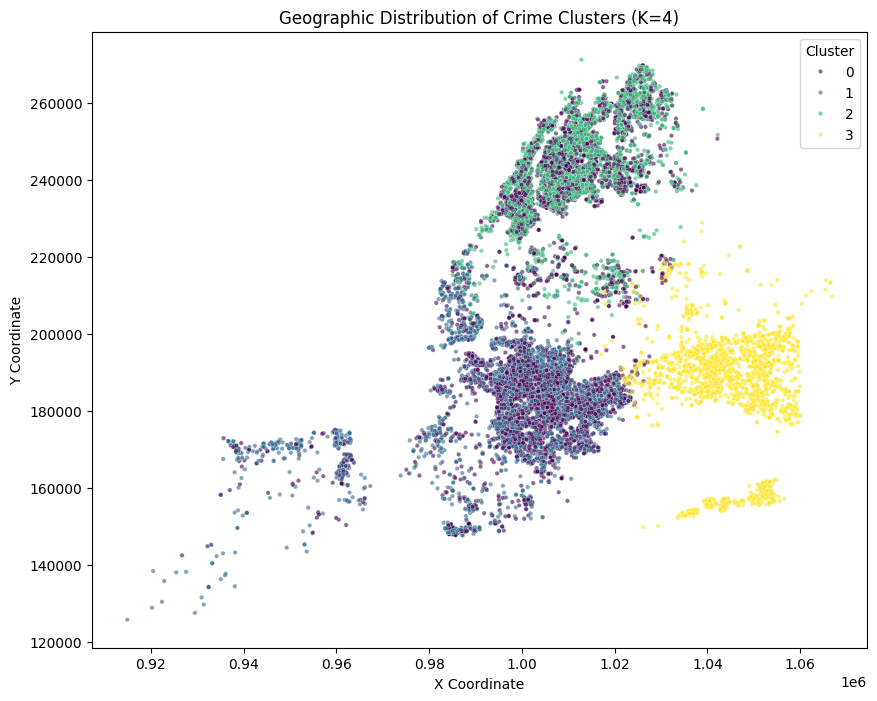

In [19]:
print("=== PROJECT: FINAL CLUSTERING ANALYSIS (K=4) ===")

# 1. אימון המודל המנצח (4 קבוצות)
kmeans_final = KMeans(n_clusters=4, n_init=10, random_state=42)
X_scaled = preprocessor_linear.fit_transform(X_train[linear_cols])
kmeans_final.fit(X_scaled)

# 2. חיבור התוצאות לדאטה המקורי כדי להבין את המשמעות
# אנחנו יוצרים עותק של הדאטה המקורי ומוסיפים לו עמודה חדשה: 'Cluster'
df_analysis = X_train[linear_cols].copy()
df_analysis['Cluster'] = kmeans_final.labels_

# מוסיפים גם את עמודת המטרה המקורית (רק בשביל הניתוח, המודל לא ראה אותה!)
df_analysis['TARGET'] = y_train

# 3. יצירת "תעודת זהות" לכל קבוצה
# נחשב את הממוצע/השכיח לכל פיצ'ר בכל קבוצה
cluster_summary = df_analysis.groupby('Cluster').agg({
    'BORO': lambda x: x.mode()[0],            # איפה זה קורה הכי הרבה?
    'hour_sin': 'mean',                       # אינדיקציה לשעה (צריך לפרש בזהירות)
    'is_night_outdoor': 'mean',               # אחוז פשעי הלילה בחוץ
    'VIC_SEX': lambda x: x.mode()[0],         # מי הקורבן הטיפוסי?
    'PERP_RACE': lambda x: x.mode()[0],       # מוצא החשוד הטיפוסי
    'TARGET': 'mean',                         # % הפשעים החמורים בקבוצה (מעניין!)
    'X_COORD_CD': 'count'                     # גודל הקבוצה
}).rename(columns={'X_COORD_CD': 'Size', 'TARGET': '% Severe Crimes'})

# סידור הטבלה
cluster_summary['Size %'] = (cluster_summary['Size'] / len(df_analysis)) * 100
print("\n--- Crime Profiles Detected (K=4) ---")
print(cluster_summary)

# 4. בונוס: ויזואליזציה גיאוגרפית של הקבוצות
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_analysis, 
    x='X_COORD_CD', 
    y='Y_COORD_CD', 
    hue='Cluster', 
    palette='viridis', 
    s=10, 
    alpha=0.6
)
plt.title('Geographic Distribution of Crime Clusters (K=4)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()

=== PROJECT: FINAL DBSCAN (Hotspot Detection) ===
Running DBSCAN to find dense crime hotspots...

Result: Found 5 Hotspots.
Noise points (random crimes): 13419 out of 23795


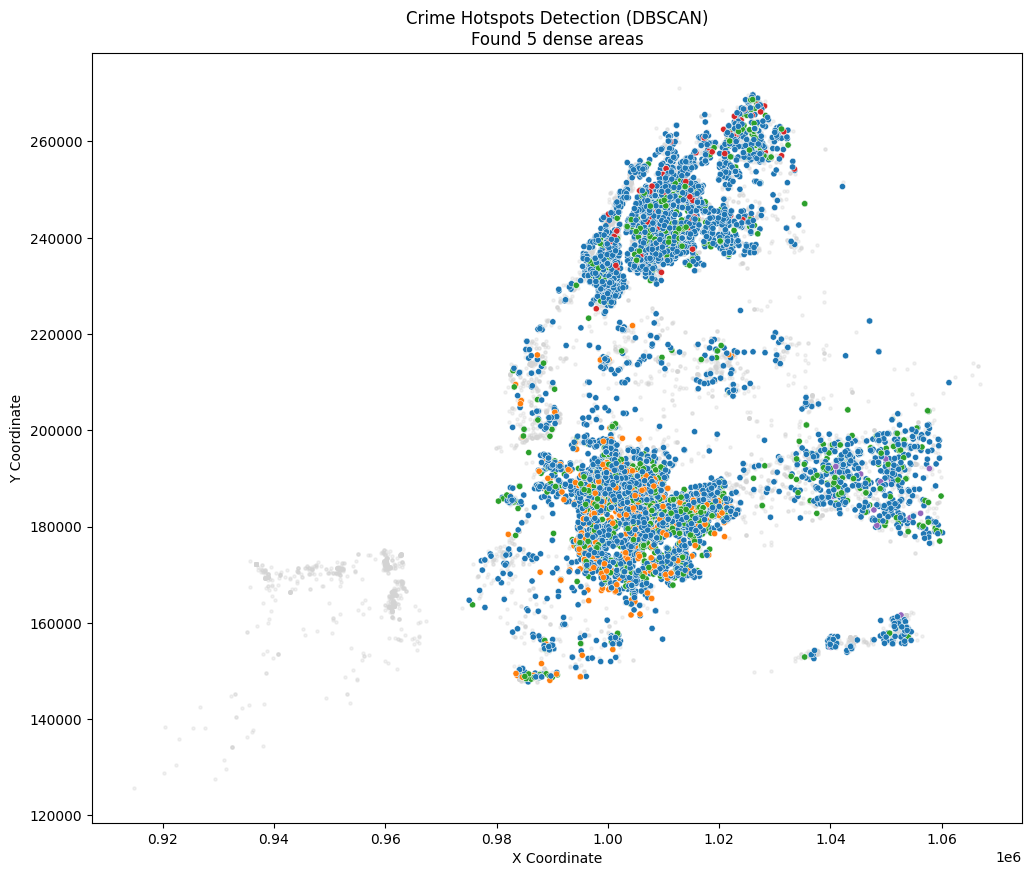

In [20]:
from sklearn.cluster import DBSCAN

print("=== PROJECT: FINAL DBSCAN (Hotspot Detection) ===")

# 1. הכנת הדאטה (שימוש באותו סקיילינג מקודם)
# DBSCAN רגיש מאוד למרחקים, אז ה-Scaling קריטי
X_scaled = preprocessor_linear.fit_transform(X_train[linear_cols])

# 2. הרצת DBSCAN
# eps=0.5: רדיוס החיפוש (ככל שקטן יותר - מוצא רק צפיפות גבוהה מאוד)
# min_samples=10: מינימום פשעים כדי להגדיר "כנופיה" או "מוקד"
print("Running DBSCAN to find dense crime hotspots...")
dbscan = DBSCAN(eps=2.0, min_samples=20) 
dbscan.fit(X_scaled)

# 3. ניתוח התוצאות
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"\nResult: Found {n_clusters} Hotspots.")
print(f"Noise points (random crimes): {n_noise} out of {len(X_train)}")

# 4. ויזואליזציה של ה-Hotspots
# אנחנו רוצים לראות רק את הקלאסטרים הגדולים, ולהתעלם מהרעש (נקודות אפורות)
df_plot = X_train.copy()
df_plot['Cluster'] = labels

plt.figure(figsize=(12, 10))

# צייר קודם את ה"רעש" באפור חלש
plt.scatter(
    df_plot[df_plot['Cluster'] == -1]['X_COORD_CD'], 
    df_plot[df_plot['Cluster'] == -1]['Y_COORD_CD'], 
    c='lightgrey', label='Noise (Random Crime)', s=5, alpha=0.3
)

# צייר את ה-Hotspots בצבעים
# נסנן רק את הקלאסטרים האמיתיים
clustered_data = df_plot[df_plot['Cluster'] != -1]
sns.scatterplot(
    data=clustered_data,
    x='X_COORD_CD', 
    y='Y_COORD_CD', 
    hue='Cluster', 
    palette='tab10', # פלטה צבעונית בולטת
    s=20, 
    legend=False # יותר מדי קלאסטרים למקרא
)

plt.title(f'Crime Hotspots Detection (DBSCAN)\nFound {n_clusters} dense areas')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()